In [ ]:
%load_ext autoreload
%autoreload 2


from liftout.structures import Sample, load_experiment


import os 
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
# path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM" # 6
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM" # 3

sample = load_experiment(path)
sample.__to_dataframe__()

### Log Parsing (new)

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from copy import deepcopy
from dataclasses import dataclass

from pathlib import Path

from liftout.tools.data import calculate_statistics_dataframe, AutoLiftoutStatistics, calculate_aggregated_statistics


# paths = [
#     r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM",
#     r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM"
# ]

path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-08-2022-10-18.10-39-45AM"
df = calculate_statistics_dataframe(path)


df.click

In [ ]:
df = calculate_aggregated_statistics(paths)
display(df)

In [ ]:
# specimen current
microscope.state.specimen_current.value

## System Settings
Set / Restore system settings


In [ ]:
%load_ext autoreload
%autoreload 2
from fibsem import utils, calibration
from fibsem.structures import BeamSystemSettings, SystemSettings, BeamType

from autoscript_sdb_microscope_client import SdbMicroscopeClient

from pprint import pprint 

In [ ]:
microscope, settings = utils.setup_session()

In [ ]:
eb_settings = calibration.get_current_beam_system_state(microscope, BeamType.ELECTRON)
ib_settings = calibration.get_current_beam_system_state(microscope, BeamType.ION)
pprint(eb_settings)
pprint(ib_settings)

In [ ]:
from dataclasses import asdict
# check if settings are different
for i, (a, b) in enumerate(list(zip(asdict(eb_settings).values(), asdict(settings.system.electron).values()))):

    if a != b:
        k = list(asdict(eb_settings).keys())[i]
        print("not equal: ", k, a, b)

## History Bug

In [ ]:
%load_ext autoreload
%autoreload 2

from liftout.structures import create_experiment, Lamella, AutoLiftoutStage
from liftout.autoliftout import update_sample_lamella_data
from fibsem import utils
from pprint import pprint
from liftout import autoliftout


microscope, settings = utils.setup_session()
os.makedirs("test", exist_ok=True)
sample = create_experiment("test-history", "test")


In [ ]:
lamella = Lamella(sample.path, 1)
sample = update_sample_lamella_data(sample, lamella)

stages = [stage for stage in AutoLiftoutStage][2:]

for stage in stages:
    print(stage)
    pprint(sample)
    pprint(sample.positions[1])

    lamella.current_state.stage = stage
    sample = autoliftout.end_of_stage_update(microscope, sample, lamella, )
    
    pprint(sample)
    pprint(sample.positions[1])
    pprint([state.stage.name for state in sample.positions[1].history])
    print("-"*50)

## Initial Calibration

Set the initial grid states 

set the initial calibration (eucentric, horizontal shift, needle)

## New AutoLiftout UI

autoliftout ui in napari


In [ ]:
%load_ext autoreload
%autoreload 2

from liftout.structures import load_experiment, Sample
from autoscript_sdb_microscope_client.structures import AdornedImage
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import napari
from liftout import autoliftout

# pprint(sample)


In [ ]:
DISPLAY_REFERENCE_FNAMES = [
    "ref_lamella_low_res_ib",
    "ref_trench_high_res_ib",
    "ref_jcut_high_res_ib",
    "ref_liftout_ib",
    "ref_landing_lamella_high_res_ib",
    "ref_reset_high_res_ib",
    "ref_thin_lamella_post_superres_ib",
    "ref_polish_lamella_post_superres_ib",
]

headers = [
    "Sample No",
    "Position",
    "Reference",
    "Milling",
    "J-Cut",
    "Liftout",
    "Landing",
    "Reset",
    "Thinning",
    "Polishing",
]

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(overview_image, cmap="gray")
plt.show()

In [ ]:
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM" # 6
# path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM" # 3

from liftout.gui.utils import create_overview_image
sample = load_experiment(path)

# TODO: stage labels, lamella labels

overview_image = create_overview_image(sample)
viewer = napari.Viewer()
viewer.add_image(overview_image, name="AutoLiftout")

In [ ]:

%load_ext autoreload
%autoreload 2

from fibsem import utils

microscope, settings = utils.setup_session(session_path = "xyz")

In [ ]:
settings.image.save_path

In [ ]:
from gc import is_finalized
from liftout.structures import AutoLiftoutStage, load_experiment, Lamella, Sample

path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-05_2022-08-29.11-57-03AM" # 6
# path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-06_2022-08-30.03-26-27PM" # 3

from liftout.gui.utils import create_overview_image
sample = load_experiment(path)


def get_completion_stats(sample: Sample) -> tuple:
    """Get the current completetion stats for lifout"""    
    n_stages = AutoLiftoutStage.Polishing.value # init and failure dont count

    lam: Lamella
    active_lam = 0
    completed_stages = 0
    for lam in sample.positions.values():

        # dont count failure
        if lam.is_failure or lam.current_state.stage.value == 99:
            continue
        
        active_lam += 1
        completed_stages += lam.current_state.stage.value

    total_stages = n_stages * active_lam
    perc_complete = completed_stages / total_stages


    return n_stages, active_lam, completed_stages, total_stages, perc_complete


n_stages, active_lam, completed_stages, total_stages, perc_complete = get_completion_stats(sample)

print(completed_stages, active_lam, total_stages, perc_complete)


In [ ]:
settings.default

In [ ]:
%load_ext autoreload
%autoreload 2

from fibsem import utils, acquire
import matplotlib.pyplot as plt
from liftout import actions
from fibsem import movement, acquire

microscope, settings = utils.setup_session()

In [ ]:


actions.move_needle_to_reset_position(microscope)
acquire.take_reference_images(microscope, settings.image)


In [ ]:
movement.retract_needle(microscope)

In [ ]:

%load_ext autoreload
%autoreload 2

from liftout.utils import crosscorrelate_and_plot
from autoscript_sdb_microscope_client.structures import AdornedImage
import matplotlib.pyplot as plt

p1 = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-08-2022-10-18.10-39-45AM\02-next-bison/2022-10-18.02-10-48PM_eb.tif"
p2 = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-08-2022-10-18.10-39-45AM\02-next-bison/ref_trench_low_res_ib.tif"

img1 = AdornedImage.load(p1)
img2 = AdornedImage.load(p2)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1.data)
ax[1].imshow(img2.data)
plt.show()



In [ ]:
from fibsem.utils import setup_session, load_settings_from_config
from liftout.config import config
from fibsem.imaging import masks
from fibsem.imaging import utils as image_utils

settings = load_settings_from_config(
    config_path = config.config_path,
    protocol_path = config.protocol_path
)


plt.imshow(image_utils.rotate_image(img2).data)
plt.show()

# ref_mask = masks.create_lamella_mask(image_utils.rotate_image(img2), settings.protocol["lamella"], scale = 4, use_trench_height=True) # TODO: refactor, liftout specific

crosscorrelate_and_plot(img2, img1, rotate=True)

In [ ]:
from fibsem import alignment


# rotate 
img1_r = image_utils.rotate_image(img1)


# normalise images
img1_norm = image_utils.normalise_image(img1_r.data)
img2_norm = image_utils.normalise_image(img2.data)

# create bandpass
lp=128
hp=6
sigma =6
bandpass = masks.create_bandpass_mask(shape=img1_norm.shape, lp=lp, hp=hp, sigma=sigma)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1_norm, cmap="gray")
ax[1].imshow(img1_norm, cmap="gray")
plt.show()

plt.imshow(bandpass)
plt.show()

# crosscorrelation
xcorr = alignment.crosscorrelation_v2(img1_norm, img2_norm, bandpass=bandpass)
plt.imshow(xcorr)
plt.show()

xcorr = masks.apply_circular_mask(xcorr, 512)
plt.imshow(xcorr)
plt.show()



In [ ]:
# lamella freq

from fibsem import conversions

import os
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-08-2022-10-18.10-39-45AM\02-next-bison"


low_res_ib = AdornedImage.load(os.path.join(path, "ref_trench_low_res_ib.tif"))
high_res_ib = AdornedImage.load(os.path.join(path, "ref_trench_high_res_ib.tif"))

h, w = conversions.get_lamella_size_in_pixels(low_res_ib, settings.protocol["lamella"], use_trench_height=True)
print(f"h: {h}, w:{w}")

h, w = conversions.get_lamella_size_in_pixels(high_res_ib, settings.protocol["lamella"], use_trench_height=True)
print(f"h: {h}, w:{w}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(low_res_ib.data, cmap="gray")
ax[1].imshow(high_res_ib.data, cmap="gray")
plt.show()

# TODO: convert these sizes to lp, hp values

In [ ]:
protocol = {"width": 2e-6, "height": 1e-6, "depth": 2e-6, 
    "number": 3, "offset": 1e-6, 
    "scan_direction": "RightToLeft", 
    "cleaning_cross_section": False,
    "milling_current": 2e-9}


from liftout import patterning 
microscope.patterning.clear_patterns()

from fibsem.structures import Point

patterning.spot_weld_pattern(microscope, protocol, Point(5e-6, -2e-6))



In [ ]:
%load_ext autoreload
%autoreload 2

from fibsem.utils import setup_session, load_settings_from_config
from liftout.config import config
from fibsem.imaging import masks
from fibsem.imaging import utils as image_utils

from liftout.utils import crosscorrelate_and_plot
from autoscript_sdb_microscope_client.structures import AdornedImage
import matplotlib.pyplot as plt

settings = load_settings_from_config(
    config_path = config.config_path,
    protocol_path = config.protocol_path
)

ref_path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-09-2022-10-21.11-32-09AM\01-fast-bedbug/ref_trench_jcut_low_res_ib.tif"
target_path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-09-2022-10-21.11-32-09AM\01-fast-bedbug/2022-10-21.01-35-09PM_eb.tif"
# target_path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-09-2022-10-21.11-32-09AM\01-fast-bedbug/2022-10-21.01-30-34PM_eb.tif"


ref_path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-09-2022-10-21.11-32-09AM\01-fast-bedbug/ref_trench_jcut_high_res_ib.tif"
target_path = r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-09-2022-10-21.11-32-09AM\01-fast-bedbug/2022-10-21.01-17-38PM_eb.tif"


ref_image = AdornedImage.load(ref_path)
target_image = AdornedImage.load(target_path)

ref_mask = masks.create_lamella_mask(
    ref_image, settings.protocol["lamella"], scale=4, use_trench_height=True
)  # TODO: refactor, liftout specific

crosscorrelate_and_plot(ref_image, target_image, ref_mask=ref_mask,
    rotate=True, xcorr_limit=250)


In [1]:
%load_ext autoreload
%autoreload 2

from fibsem import alignment, acquire, utils, calibration
from liftout.utils import take_reference_images_and_plot

microscope, settings = utils.setup_session()

# take_reference_images_and_plot(microscope, settings.image)




2022-10-25 16:41:15,075 — root — INFO — connect_to_microscope:31 — Microscope client connecting to [10.0.0.1]
2022-10-25 16:41:15,083 — root — INFO — connect_to_microscope:34 — Microscope client connected to [10.0.0.1]
2022-10-25 16:41:15,084 — root — INFO — setup_session:264 — Finished setup for session: demo_2022-10-25.04-41-15PM


Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]


In [ ]:

alignment.auto_eucentric_correction(microscope, settings.image)

take_reference_images_and_plot(microscope, settings.image)


##  Needle Testing

2022-10-25 16:41:23,204 — root — INFO — retract_multichem:43 — retracting multichem
2022-10-25 16:41:23,208 — root — INFO — retract_multichem:46 — retract multichem complete
2022-10-25 16:41:23,210 — root — INFO — retract_needle:63 — retracting needle to ManipulatorPosition(x=-0.00045474043, y=4.8442912e-05, z=5.4957692e-05, coordinate_system=Raw)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2022-10-25 16:41:27,615 — root — INFO — retract_needle:67 — retracting needle...
2022-10-25 16:41:27,619 — root — INFO — retract_needle:69 — retract needle complete
2022-10-25 16:41:33,239 — root — INFO — insert_needle:38 — inserted needle to ManipulatorPosition(x=-0.00045474043, y=4.8442912e-05, z=5.4957692e-05, coordinate_system=Raw).
2022-10-25 16:41:36,530 — root — INFO — autocontrast:27 — automatically adjusting contrast...
2022-10-25 16:41:37,329 — root — INFO — acquire_image:186 — acquiring new ELECTRON image.
2022-10-25 16:41:39,362 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Electron | -63.361 | 0.366
2022-10-25 16:41:39,401 — root — INFO — autocontrast:27 — automatically adjusting contrast...
2022-10-25 16:41:39,996 — root — INFO — acquire_image:186 — acquiring new ION image.
2022-10-25 16:41:41,856 — root — INFO — auto_gamma:86 — AUTO_GAMMA | Ion | -46.083 | 0.539


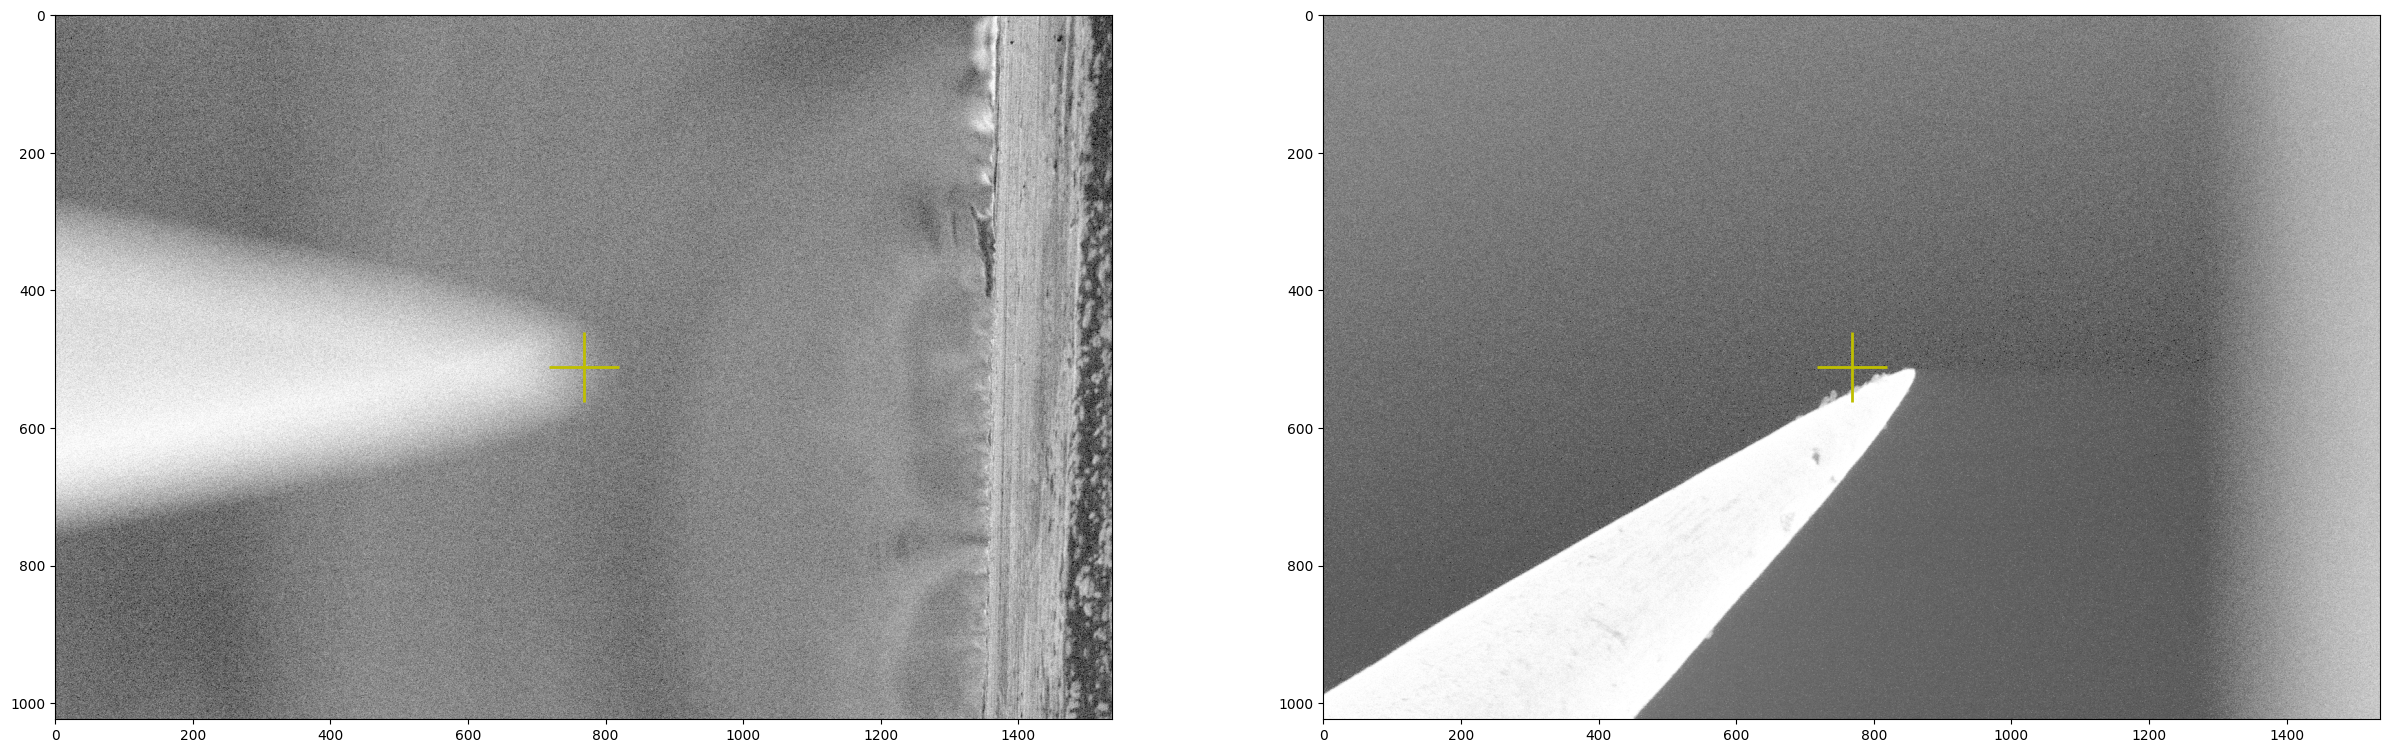

(AdornedImage(width=1536, height=1024, bit_depth=8),
 AdornedImage(width=1536, height=1024, bit_depth=8))

In [2]:
%load_ext autoreload
%autoreload 2
from liftout import actions
from fibsem import movement


movement.retract_needle(microscope)

actions.move_needle_to_reset_position(microscope)
# actions.move_needle_to_liftout_position(microscope)
# actions.move_needle_to_landing_position(microscope)
# movement.move_needle_to_position_offset(microscope, None, dz=10e-6)
# movement.insert_needle(microscope)

take_reference_images_and_plot(microscope, settings.image)

# from autoscript_sdb_microscope_client.structures import (
#     ManipulatorPosition,
#     MoveSettings,
#     StagePosition,
# )

# from autoscript_sdb_microscope_client.enumerations import (
#     ManipulatorCoordinateSystem,
#     ManipulatorSavedPosition,
# )

# microscope.specimen.manipulator.insert()
# movement.insert_needle(microscope, ManipulatorSavedPosition.EUCENTRIC)

In [ ]:
take_reference_images_and_plot(microscope, settings.image)

In [ ]:
from fibsem.detection import detection
from fibsem.detection.detection import DetectionFeature, DetectionType

from fibsem.detection import utils as det_utils

from fibsem.structures import BeamType

settings.image.beam_type = BeamType.ELECTRON
settings.image.hfw = 400e-6

image = acquire.new_image(microscope, settings.image)
det = detection.locate_shift_between_features(
    image,
    features=[
        DetectionFeature(DetectionType.NeedleTip, None),
        DetectionFeature(DetectionType.ImageCentre, None),
    ],
)

det_utils.plot_detection_result(det)

## Auto Home and Link

Steps:
1. Home the stage
2. Restore state
3. Focus and Link

Questions:
what is the initial state?

In [6]:
%load_ext autoreload
%autoreload 2

from fibsem import calibration
from fibsem.structures import MicroscopeState
from fibsem.utils import save_yaml, load_yaml
from fibsem import config 
from pathlib import Path

# state = calibration.get_current_microscope_state(microscope)

from fibsem import alignment, acquire, utils, calibration
from liftout.utils import take_reference_images_and_plot

microscope, settings = utils.setup_session()
path = os.path.join(config.CONFIG_PATH, "calibrated_state.yaml")
# save_state_yaml(path, state)

state = MicroscopeState.__from_dict__(load_yaml(path))

calibration.auto_home_and_link(microscope)


2022-10-21 18:46:17,138 — root — INFO — connect_to_microscope:31 — Microscope client connecting to [10.0.0.1]
2022-10-21 18:46:17,142 — root — INFO — connect_to_microscope:34 — Microscope client connected to [10.0.0.1]
2022-10-21 18:46:17,143 — root — INFO — setup_session:264 — Finished setup for session: demo_2022-10-21.06-46-17PM
2022-10-21 18:46:17,148 — root — INFO — auto_home_and_link:295 — Homing stage...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]
MicroscopeState(timestamp=1666335913.457053, absolute_position=StagePosition(x=0.0065565, y=-0.00739075, z=0.023155639, t=-7.80505e-07, r=0.85529431, coordinate_system=Raw), eb_settings=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=0.014370575043736882, beam_current=5e-11, hfw=0.0004, resolution='1536x1024', dwell_time=5e-07), ib_settings=BeamSettings(beam_type=<BeamType.ION: 2>, working_distance=0.016544666950390034, beam_current=2e-11, hfw=0.0004, resolution='1536x1024', dwell_time=2e-07))


2022-10-21 18:47:14,024 — root — INFO — set_microscope_state:360 — restoring microscope state...
2022-10-21 18:47:17,613 — root — INFO — safe_absolute_stage_movement:340 — safe moving to StagePosition(x=0.0065565, y=-0.00739075, z=0.023155639, t=-7.80505e-07, r=0.85529431, coordinate_system=Raw)
2022-10-21 18:47:31,021 — root — INFO — safe_absolute_stage_movement:342 — safe movement complete.
2022-10-21 18:47:31,021 — root — INFO — set_microscope_state:368 — restoring electron beam settings...
2022-10-21 18:47:36,953 — root — INFO — set_microscope_state:389 — restoring ion beam settings...
2022-10-21 18:47:52,001 — root — INFO — set_microscope_state:407 — microscope state restored
2022-10-21 18:47:52,002 — root — INFO — auto_home_and_link:307 — Linking stage...
2022-10-21 18:47:52,005 — root — INFO — autocontrast:27 — automatically adjusting contrast...
